<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn2%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:


# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
#x_train = (x_train.astype("float32") - 127.5) / 127.5
#y_train = y_train.reshape(-1, 1)
x_train = (x_train.astype("float32")) / np.max(x_train)

11490434/11490434 [==============================] - 0s 0us/step


New dataset shape: (100, 28, 28)


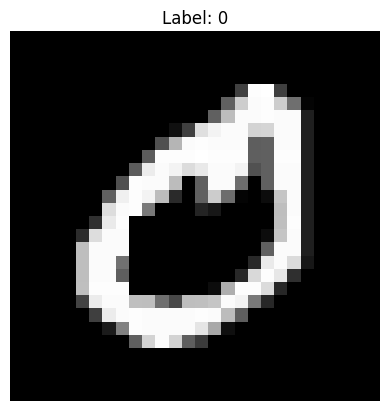

In [4]:
new_images = []
new_labels = []

for digit in set(y_train):
    digit_indices = np.where(y_train == digit)[0][:10]
    for index in digit_indices:
        image = x_train[index]
        label = y_train[index]
        new_images.append(image)
        new_labels.append(label)

new_images = np.array(new_images)
new_labels = np.array(new_labels)

print("New dataset shape:", new_images.shape)

# Visualize the new dataset
plt.imshow(new_images[1], cmap="gray")
plt.title("Label: {}".format(new_labels[1]))
plt.axis("off")
plt.show()

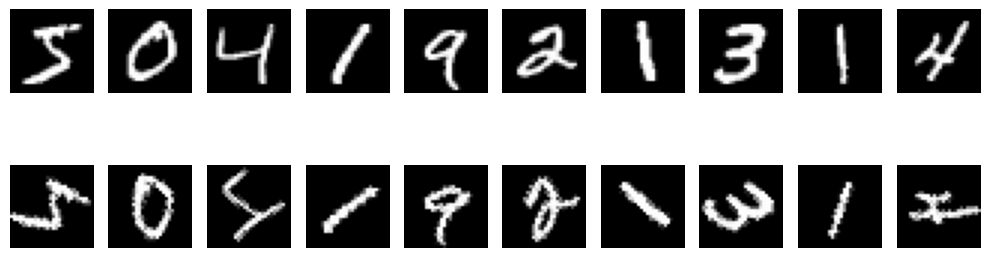

In [5]:
def random_rotate_images(images, min_angle=-90):
    size = tf.shape(images)[0]
    random_angles = tf.random.uniform(shape=(size,), minval=min_angle, maxval=-min_angle, dtype=tf.float32)
    rotated_images = tfa.image.rotate(images, random_angles / 90)
    return rotated_images

# Select a batch of images
batch_size = 10
batch_images = x_train[:batch_size]
batch_images = np.expand_dims(batch_images, axis=-1)
rotated_images = random_rotate_images(batch_images)

fig, axes = plt.subplots(nrows=2, ncols=batch_size, figsize=(10, 4))
for i in range(batch_size):
    axes[0][i].imshow(batch_images[i], cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow(rotated_images[i], cmap='gray')
    axes[1][i].axis('off')
plt.tight_layout()
plt.show()


In [6]:
def build_generator():
    noise_shape = (100,)
    noise = layers.Input(shape=noise_shape)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 10)(input_digit)
    digit_embedding = layers.Flatten()(digit_embedding)

    x = layers.Concatenate()([noise, digit_embedding])

    # Transform the concatenated vector into a 7x7x256 tensor
    x = layers.Dense(7 * 7, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 1))(x)

    # Upsample to 14x14
    x = layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Conv 14x14
    x = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Upsample to 28x28
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    # Final output layer
    output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='hard_sigmoid')(x)

    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=output)
    return model

generator = build_generator()
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        100         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 10)           0           ['embedding[0][0]']              
                                                                                              

In [25]:
def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding_2d = layers.Embedding(10, 10)(digit_input)
    digit_embedding_2d = layers.Flatten()(digit_embedding_2d)
    #digit_embedding_2d = layers.Reshape((28, 28, 1))(digit_embedding_2d)

    #merged_input = layers.Concatenate()([input_image, digit_embedding_2d])

    # Convolutional layers
    x = layers.Conv2D(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_image)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(248, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(248, (5, 5), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Concatenate()([x,digit_embedding_2d])
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(300, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator_copy = build_discriminator()
#discriminator.summary()


In [26]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)
copy_optimizer = tf.keras.optimizers.Adam(0.0004)

#generator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)
#discriminator_optimizer = tf.keras.optimizers.experimental.SGD(1e-4)

In [27]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



In [28]:
def print_img(generator_model):
    # Generate and save sample images
    noise = tf.random.normal([10, 100])
    sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
    generated_images = generator_model.predict([noise, sampled_labels])
    fig, axs = plt.subplots(1, 10, figsize=(10, 10))
    for i in range(10):
        axs[i].imshow(generated_images[i], cmap="gray")
        axs[i].axis("off")
    plt.show()

disc_loss 1.13141704 gen_loss 0.832051933
disc_loss 1.18527603 gen_loss 0.761696219
disc_loss 1.25179505 gen_loss 0.628958106
disc_loss 1.20700622 gen_loss 0.808811128
disc_loss 1.23909259 gen_loss 0.693086267
disc_loss 1.16327631 gen_loss 0.895401716
disc_loss 1.18810964 gen_loss 0.734527
disc_loss 1.11146605 gen_loss 0.966934204
disc_loss 1.21144545 gen_loss 0.749809
disc_loss 1.18853569 gen_loss 0.754984736
Epoch 5/2000000
1/1 [==============================] - 0s 56ms/step


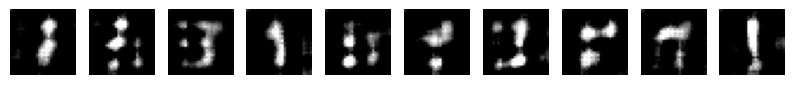

disc_loss 1.29095817 gen_loss 0.840519249
disc_loss 1.18607223 gen_loss 0.669330657
disc_loss 1.23625588 gen_loss 0.7362414
disc_loss 1.11167586 gen_loss 0.82275492
disc_loss 1.19373083 gen_loss 0.691768408
disc_loss 1.05958652 gen_loss 1.04718876
disc_loss 1.20969605 gen_loss 0.733486652
disc_loss 1.11618531 gen_loss 0.884228349
disc_loss 1.26178145 gen_loss 0.895395756
disc_loss 1.12557673 gen_loss 0.758690715
Epoch 10/2000000
1/1 [==============================] - 0s 33ms/step


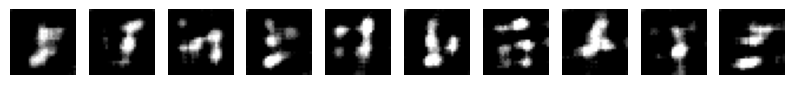

disc_loss 1.20564687 gen_loss 0.817432463
disc_loss 1.06700873 gen_loss 0.94831413
disc_loss 1.16663027 gen_loss 0.726496816
disc_loss 1.02523923 gen_loss 1.02932513
disc_loss 1.14342177 gen_loss 0.71589
disc_loss 1.02301013 gen_loss 1.02874279
disc_loss 1.14107442 gen_loss 0.782453299
disc_loss 1.02451277 gen_loss 0.973479629
disc_loss 1.09955096 gen_loss 0.753997207
disc_loss 0.964600682 gen_loss 1.1382724
Epoch 15/2000000
1/1 [==============================] - 0s 32ms/step


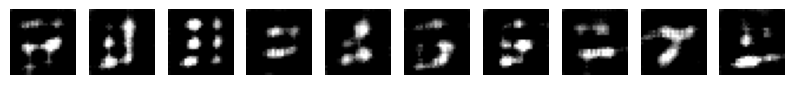

disc_loss 1.05485618 gen_loss 0.779419303
disc_loss 0.92218703 gen_loss 1.32659817
disc_loss 0.993999362 gen_loss 1.05639505
disc_loss 0.779018044 gen_loss 1.15049553
disc_loss 0.909636199 gen_loss 0.966937661
disc_loss 0.674599886 gen_loss 1.45890987
disc_loss 0.934533954 gen_loss 0.381543547
disc_loss 0.957449138 gen_loss 1.35154879
disc_loss 0.970915079 gen_loss 1.23443222
disc_loss 0.740991771 gen_loss 1.11468577
Epoch 20/2000000
1/1 [==============================] - 0s 37ms/step


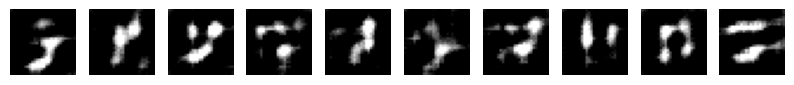

disc_loss 0.941590786 gen_loss 1.41346395
disc_loss 0.704699337 gen_loss 1.94859159
disc_loss 0.888762653 gen_loss 1.79061067
disc_loss 0.742714226 gen_loss 1.73635745
disc_loss 0.887353659 gen_loss 1.63229823
disc_loss 0.755713105 gen_loss 1.61418879
disc_loss 0.784600139 gen_loss 1.78579557
disc_loss 0.701185465 gen_loss 1.98396158
disc_loss 0.707452059 gen_loss 2.05813336
disc_loss 0.663897634 gen_loss 2.24978614
Epoch 25/2000000
1/1 [==============================] - 0s 34ms/step


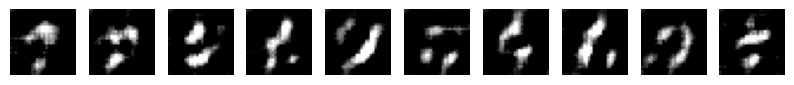

disc_loss 0.68114692 gen_loss 1.89003134
disc_loss 0.58105123 gen_loss 2.01883245
disc_loss 0.672595263 gen_loss 1.70303333
disc_loss 0.503243327 gen_loss 2.24170232
disc_loss 0.634723246 gen_loss 1.09541678
disc_loss 0.493270069 gen_loss 1.74131465
disc_loss 0.539315343 gen_loss 2.16656303
disc_loss 0.3501091 gen_loss 2.6855514
disc_loss 0.442022204 gen_loss 2.80704618
disc_loss 0.383609176 gen_loss 1.33035624
Epoch 30/2000000
1/1 [==============================] - 0s 58ms/step


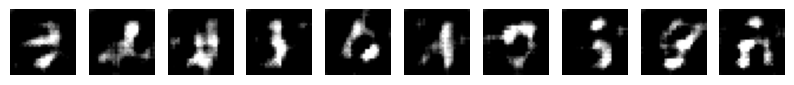

disc_loss 1.06743968 gen_loss 2.65389729
disc_loss 0.94599843 gen_loss 1.36525762
disc_loss 0.807934165 gen_loss 1.29816329
disc_loss 0.58035481 gen_loss 1.90034938
disc_loss 0.735050738 gen_loss 2.10148549
disc_loss 0.531683862 gen_loss 1.96332026
disc_loss 0.911542 gen_loss 1.99002731
disc_loss 0.545502 gen_loss 2.2841959
disc_loss 0.683244407 gen_loss 2.08281684
disc_loss 0.501355052 gen_loss 2.18301749
Epoch 35/2000000
1/1 [==============================] - 0s 33ms/step


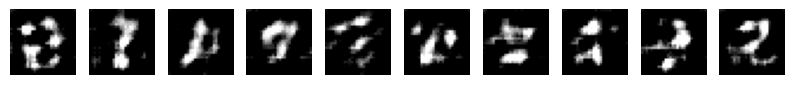

disc_loss 0.511259675 gen_loss 1.75468659
disc_loss 0.354394 gen_loss 3.1779592
disc_loss 0.425154626 gen_loss 1.92280364
disc_loss 0.315209091 gen_loss 3.75926208
disc_loss 0.664021 gen_loss 3.55329466
disc_loss 0.370901823 gen_loss 3.67088604
disc_loss 0.644835413 gen_loss 2.60732627
disc_loss 0.441046536 gen_loss 2.16150713
disc_loss 0.628092408 gen_loss 2.44649434
disc_loss 0.707616031 gen_loss 2.24439073
Epoch 40/2000000
1/1 [==============================] - 0s 35ms/step


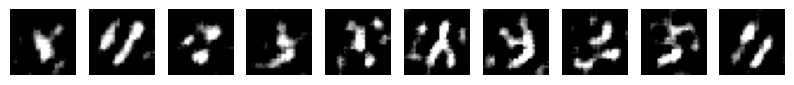

disc_loss 0.735027969 gen_loss 1.6290555
disc_loss 0.41666165 gen_loss 2.39476609
disc_loss 0.638552845 gen_loss 1.92596102
disc_loss 0.441770673 gen_loss 2.24358034
disc_loss 0.557100534 gen_loss 2.3586936
disc_loss 0.411237 gen_loss 2.90099049
disc_loss 0.477178156 gen_loss 2.05098915
disc_loss 0.343742728 gen_loss 2.52772593
disc_loss 0.448152065 gen_loss 2.39892435
disc_loss 0.341527313 gen_loss 3.52326226
Epoch 45/2000000
1/1 [==============================] - 0s 33ms/step


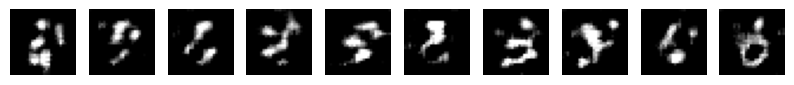

disc_loss 0.480716199 gen_loss 1.77101099


In [ ]:
#@tf.function
def train_step(images, labels):

    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 100])
    generated_images = generator([noise, labels], training=True)



    with tf.GradientTape() as disc_tape:

      real_output = discriminator([images, labels], training=True)
      fake_output = discriminator([generated_images, labels], training=True)

      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    # Get the weights of model1
    weights = discriminator.get_weights()

    # Set the weights of model2 to be the same as model1
    discriminator_copy.set_weights(weights)

    for i in range(5):
      with tf.GradientTape() as disc_copy_tape:
        noise = tf.random.normal([batch_size, 100])
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator_copy([images, labels], training=True)
        fake_output = discriminator_copy([generated_images, labels], training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_discriminator = disc_copy_tape.gradient(disc_loss, discriminator_copy.trainable_variables)
      copy_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_copy.trainable_variables))



    with tf.GradientTape() as gen_tape:
      noise = tf.random.normal([batch_size, 100])
      generated_images = generator([noise, labels], training=True)
      fake_output = discriminator_copy([generated_images, labels], training=True)
      gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    tf.print("disc_loss",disc_loss,'gen_loss',gen_loss)


def train(generator, discriminator
          , epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(new_images) // batch_size):
            images = new_images[batch * batch_size: (batch+1) * batch_size]
            labels = new_labels[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print_img(generator)

# Train the GAN
EPOCHS = 2000000
BATCH_SIZE = 50
num_unrolling_steps = 5  # Set the desired number of unrolling steps
train(generator, discriminator, EPOCHS, BATCH_SIZE)